In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
data = pd.read_excel("./data/airlines_data.xlsx")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


There is only one numeric variable, which we can easily inspect by making a histogram. The data seems slightly skewed towards the right.

<Axes: >

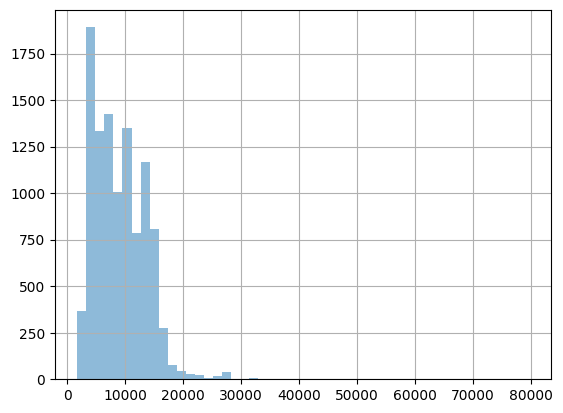

In [13]:
data["Price"].hist(bins=50, alpha=0.5)

There are just a few null values, which we can forward fill as follows:

In [7]:
data = data.ffill()

## Feature Transformation

First, let's clean up the categorical variables. There are non-identical duplicates in the `Airlines` feature. We can use `np.where()` to fix this.

In [16]:
data['Airline'].unique().tolist()

['IndiGo',
 'Air India',
 'Jet Airways',
 'SpiceJet',
 'Multiple carriers',
 'GoAir',
 'Vistara',
 'Air Asia',
 'Multiple carriers Premium economy',
 'Trujet']

In [17]:
data['Airline'] = np.where(data['Airline']=='Vistara Premium economy', 'Vistara', data['Airline'])
data['Airline'] = np.where(data['Airline']=='Jet Airways Business', 'Jet Airways', data['Airline'])
data['Airline'] = np.where(data['Airline']=='Multiple carriers Premium economy', 'Multiple carriers', data['Airline'])

In [18]:
data['Airline'].unique().tolist()

['IndiGo',
 'Air India',
 'Jet Airways',
 'SpiceJet',
 'Multiple carriers',
 'GoAir',
 'Vistara',
 'Air Asia',
 'Trujet']

Then we can grab all categorical variables and apply one-hot encoding.

In [21]:
num_features_before = len(data.columns)
data = pd.get_dummies(data=data, columns = ["Airline", 'Source', 'Destination'])
num_features_after = len(data.columns)
f"Before OH encoding there were {num_features_before} features, afterwards we have {num_features_after} features"

'Before OH encoding there were 11 features, afterwards we have 28 features'

The `Total_Stops` feature is encoded as an object, but this can be easily changed into an integer.

In [24]:
data["Total_Stops"].value_counts()

Total_Stops
1 stop      5625
non-stop    3492
2 stops     1520
3 stops       45
4 stops        1
Name: count, dtype: int64

In [29]:
data["Total_Stops"] = data["Total_Stops"].replace({"non-stop":0,"1 stop":1,"2 stops":2,"3 stops":3,"4 stops":4}).astype(int)

C:\Users\Florian-Music\AppData\Local\Temp\ipykernel_39312\4127871974.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["Total_Stops"] = data["Total_Stops"].replace({"non-stop":0,"1 stop":1,"2 stops":2,"3 stops":3,"4 stops":4}).astype(int)


In [30]:
data["Total_Stops"].value_counts()

Total_Stops
1    5625
0    3492
2    1520
3      45
4       1
Name: count, dtype: int64

### Datetime transformations

A few columns have time info, for standard data anlysis we could transform this to a datetime. But for it to be recognisable by a machine learning algorithm it is better to make it into numeric or categorical data. In this case we will split up the date and time into separate columns: `[Duration_hours, Duration_minutes, Duration_total_minutes]`.

Then we can transform the actual date information to datetime format.

In [33]:
data.head(1)

,Date_of_Journey,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Airline_Air Asia,Airline_Air India,...,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Banglore,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,24/03/2019,BLR → DEL,22:20,01:10 22 Mar,2h 50m,0,No info,3897,False,False,...,False,False,False,False,False,False,False,False,False,True


In [43]:
data[["Duration_hours", "Duration_minutes"]] = data["Duration"].str.extract(r'(?:(\d+)h)?\s*(?:(\d+)m)?').fillna(0).astype(int)
data["Duration_total_minutes"] = data["Duration_hours"] * 60 + data["Duration_minutes"]
data.head(1)

,Date_of_Journey,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Airline_Air Asia,Airline_Air India,...,Source_Mumbai,Destination_Banglore,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,Duration_hours,Duration_minutes,Duration_total_minutes
0,24/03/2019,BLR → DEL,22:20,01:10 22 Mar,2h 50m,0,No info,3897,False,False,...,False,False,False,False,False,False,True,2,50,170


In [53]:
# Transform departure time into minutes and hours
data["Dep_Hour"] = pd.to_datetime(data["Dep_Time"]).dt.hour
data["Dep_Min"] = pd.to_datetime(data["Dep_Time"]).dt.minute
# Transform arrival time into minutes and hours
data["Arrival_Hour"]= pd.to_datetime(data['Arrival_Time']).dt.hour
data["Arrival_Min"]= pd.to_datetime(data['Arrival_Time']).dt.minute

C:\Users\Florian-Music\AppData\Local\Temp\ipykernel_39312\3992068170.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["Dep_Hour"] = pd.to_datetime(data["Dep_Time"]).dt.hour
C:\Users\Florian-Music\AppData\Local\Temp\ipykernel_39312\3992068170.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["Dep_Min"] = pd.to_datetime(data["Dep_Time"]).dt.minute
C:\Users\Florian-Music\AppData\Local\Temp\ipykernel_39312\3992068170.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["Arrival_Hour"]= pd.to_datetime(data['Arrival_Time']).dt.hour
C:\Users\Florian-Music\AppDat

In [ ]:
bins = [0,6,12,18,24]
labels = ['Night','Morning','Afternoon','Evening']
# Split the departure- and arrival times into multiple zones 
data['dep_timezone'] = pd.cut(data['Dep_Hour'], bins=bins, labels=labels)
data['arr_timezone'] = pd.cut(data['Arrival_Hour'], bins=bins, labels=labels)

,Date_of_Journey,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Airline_Air Asia,Airline_Air India,...,Dep_Hour,Dep_Min,Arrival_Hour,Arrival_Min,dep_timezone,arr_timezone,Year,Month,Day,Day_of_Week
0,24/03/2019,BLR → DEL,22:20,01:10 22 Mar,2h 50m,0,No info,3897,False,False,...,22,20,1,10,Evening,Night,2019,3,24,Sunday
1,1/05/2019,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2,No info,7662,False,True,...,5,50,13,15,Night,Afternoon,2019,5,1,Wednesday
2,9/06/2019,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2,No info,13882,False,False,...,9,25,4,25,Morning,Night,2019,6,9,Sunday
3,12/05/2019,CCU → NAG → BLR,18:05,23:30,5h 25m,1,No info,6218,False,False,...,18,5,23,30,Afternoon,Evening,2019,5,12,Sunday
4,01/03/2019,BLR → NAG → DEL,16:50,21:35,4h 45m,1,No info,13302,False,False,...,16,50,21,35,Afternoon,Evening,2019,3,1,Friday


In [73]:
data[["Year", "Month", "Day", "Day_of_Week"]] = pd.to_datetime(data["Date_of_Journey"], format="%d/%m/%Y").apply(lambda dt: [dt.year, dt.month, dt.day, dt.day_name()]).to_list()

In [74]:
data.head(1)

,Date_of_Journey,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Airline_Air Asia,Airline_Air India,...,Dep_Hour,Dep_Min,Arrival_Hour,Arrival_Min,dep_timezone,arr_timezone,Year,Month,Day,Day_of_Week
0,24/03/2019,BLR → DEL,22:20,01:10 22 Mar,2h 50m,0,No info,3897,False,False,...,22,20,1,10,Evening,Night,2019,3,24,Sunday


### Feature Selection

After transforming the data, we can now select which features we are interested in. In this case we look at the following columns:

In [79]:
feature_cols = ['Total_Stops', 'Airline_Air Asia',
       'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Multiple carriers', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Source_Banglore',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Banglore', 'Destination_Cochin', 'Destination_Delhi',
       'Destination_Hyderabad', 'Destination_Kolkata', 'Destination_New Delhi',
       'Duration_hours', 'Duration_minutes', 'Duration_total_minutes', 'Dep_Hour',
       'Dep_Min', 'Price']

feature_data =  data[feature_cols]
feature_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Total_Stops                10683 non-null  int64
 1   Airline_Air Asia           10683 non-null  bool 
 2   Airline_Air India          10683 non-null  bool 
 3   Airline_GoAir              10683 non-null  bool 
 4   Airline_IndiGo             10683 non-null  bool 
 5   Airline_Jet Airways        10683 non-null  bool 
 6   Airline_Multiple carriers  10683 non-null  bool 
 7   Airline_SpiceJet           10683 non-null  bool 
 8   Airline_Trujet             10683 non-null  bool 
 9   Airline_Vistara            10683 non-null  bool 
 10  Source_Banglore            10683 non-null  bool 
 11  Source_Chennai             10683 non-null  bool 
 12  Source_Delhi               10683 non-null  bool 
 13  Source_Kolkata             10683 non-null  bool 
 14  Source_Mumbai         

<Axes: >

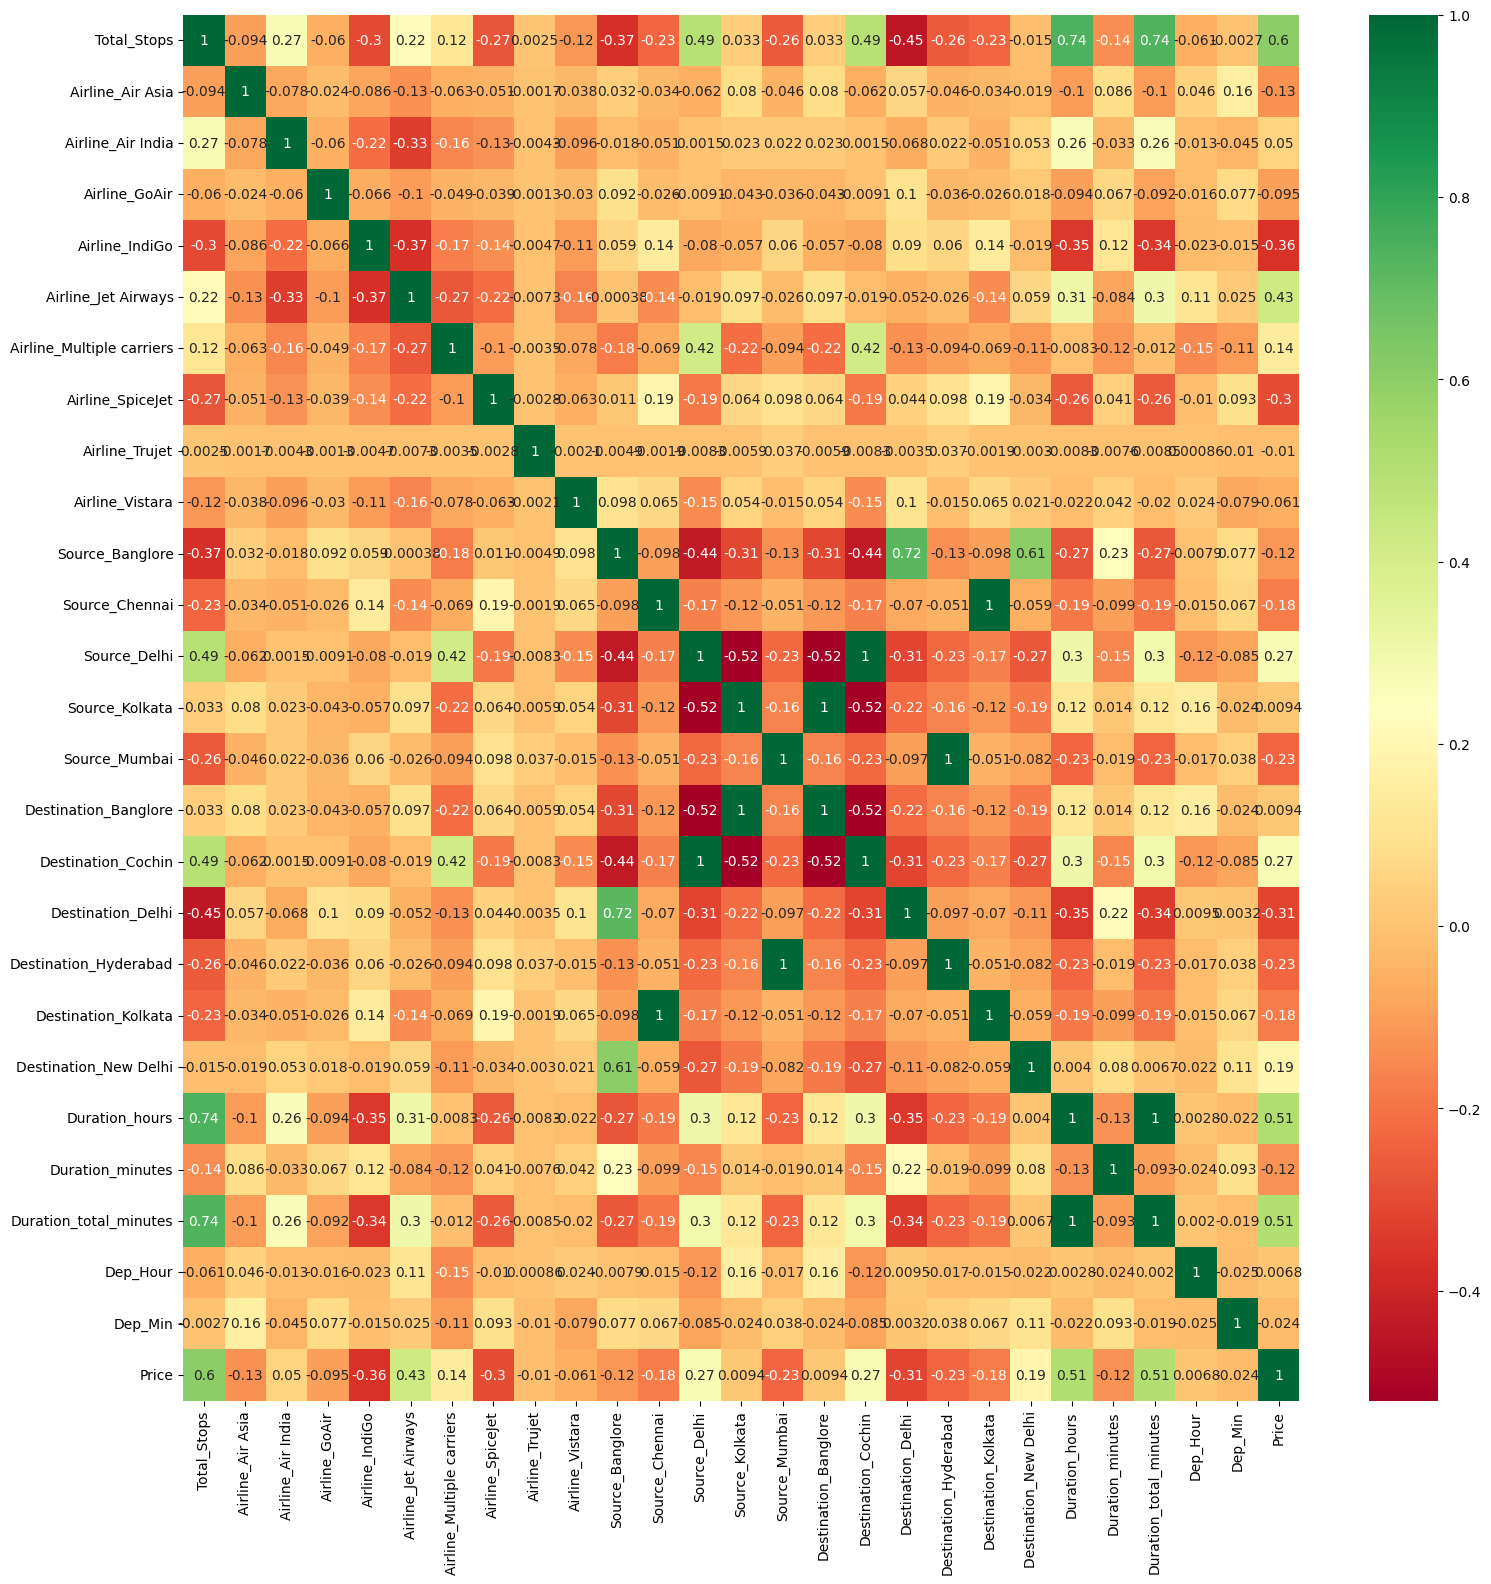

In [81]:
plt.figure(figsize=(18, 18))
sns.heatmap(feature_data.corr(), annot=True, cmap="RdYlGn")

From the heatmap we can already quickly see which variables share a strong (positive or negative) correlation. We can also inspect this numerically by inspecting the z-score and plotting.

In [82]:
features = feature_data.corr()['Price'].sort_values()
features

Airline_IndiGo              -0.361048
Destination_Delhi           -0.313401
Airline_SpiceJet            -0.296552
Source_Mumbai               -0.230745
Destination_Hyderabad       -0.230745
Destination_Kolkata         -0.179216
Source_Chennai              -0.179216
Airline_Air Asia            -0.133044
Duration_minutes            -0.124874
Source_Banglore             -0.118026
Airline_GoAir               -0.095146
Airline_Vistara             -0.060503
Dep_Min                     -0.024492
Airline_Trujet              -0.010380
Dep_Hour                     0.006819
Source_Kolkata               0.009377
Destination_Banglore         0.009377
Airline_Air India            0.050346
Airline_Multiple carriers    0.141087
Destination_New Delhi        0.189785
Source_Delhi                 0.270619
Destination_Cochin           0.270619
Airline_Jet Airways          0.428490
Duration_total_minutes       0.506371
Duration_hours               0.508672
Total_Stops                  0.603891
Price       

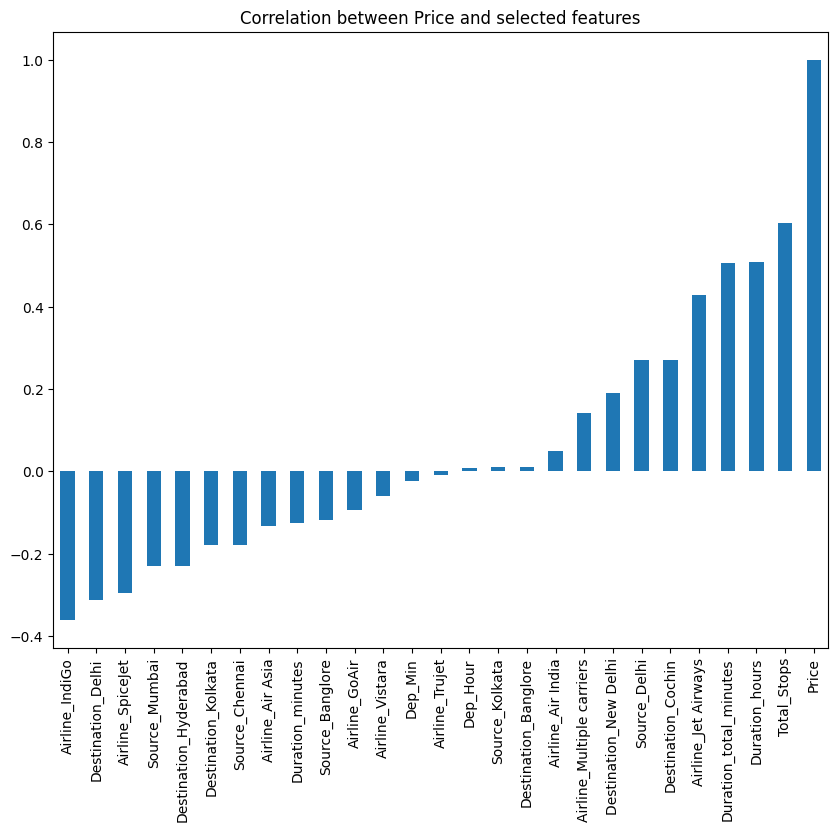

In [87]:
features.plot.bar(figsize=(10, 8), title="Correlation between Price and selected features");

## Feature Extraction with PCA

Finally, we can also use an ML model to extract features. PCA is a great tool for this, using dimensionality reduction to transform the data and grab relevant correlations.

In [126]:
feature_cols = ['Total_Stops', 'Airline_Air Asia',
       'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Multiple carriers', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Source_Banglore',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Banglore', 'Destination_Cochin', 'Destination_Delhi',
       'Destination_Hyderabad', 'Destination_Kolkata', 'Destination_New Delhi',
       'Duration_hours', 'Duration_minutes', 'Duration_total_minutes', 'Dep_Hour',
       'Dep_Min']
X = data[feature_cols]
y = data["Price"]

In [127]:
scaler = StandardScaler()
X=scaler.fit_transform(X.astype(np.float64))

In [139]:
n_components = 20
pca = PCA(n_components=n_components)
pca.fit_transform(X)

array([[-2.87559235e+00, -5.55204145e-01,  2.28555147e+00, ...,
        -3.46354729e-01,  3.49254803e-16, -7.14507793e-17],
       [ 3.18829447e-01,  2.39235354e+00, -5.95093425e-01, ...,
         1.31988869e+00,  2.53738252e-16,  9.37732066e-16],
       [ 3.05931822e+00, -5.26864592e-01, -1.58278386e-02, ...,
         6.60620476e-01, -3.68231335e-16,  2.57212602e-17],
       ...,
       [-2.24752702e+00, -5.88545787e-01,  2.08260251e+00, ...,
        -4.34210041e-02, -1.68497091e-15, -4.21040289e-17],
       [-2.69895755e+00, -2.88562626e-01,  2.56573449e+00, ...,
        -3.77239903e-01,  9.93270227e-16,  3.24640393e-16],
       [ 1.92548188e+00, -1.10426513e+00, -1.03915055e-01, ...,
         9.02384247e-01, -7.10164654e-16,  1.60676918e-15]],
      shape=(10683, 20))

In [140]:
explained_variance=pca.explained_variance_ratio_
f"Using PCA with {n_components}/{X.shape[1]} components explains {explained_variance.cumsum()[-1] * 100:.2f}% of the variance"

'Using PCA with 20/26 components explains 100.00% of the variance'

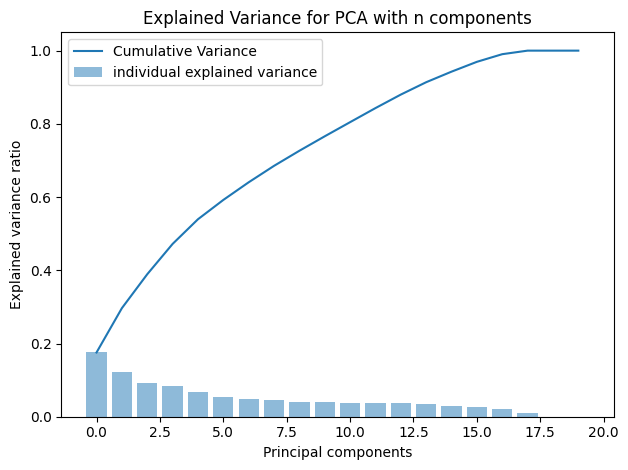

In [141]:
plt.plot(explained_variance.cumsum(), label="Cumulative Variance")
plt.title("Explained Variance for PCA with n components")
plt.xlabel("n_components")
plt.ylabel("Variance (%)")
plt.bar(range(len(explained_variance)), explained_variance, alpha=0.5, align='center',
label='individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()

From this we can see that the dimension can easily be reduced to a lower space. Since we can already reach 100% of the variance with only 20 components. Another way to handle this is to specify a float value for the `n_components` parameter. This way the fit will keep components up to an explainability ratio of `n`. A common value is 95%.

In [144]:
pca = PCA(n_components=0.95)
pca.fit_transform(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
px.area(x=range(1, cumsum.shape[0] + 1),
        y=cumsum,
        labels={"x": "# Components", "y": "Explained Variance"}
)